# 探索意图

## 使用聚类探索意图

在这本笔记本中，我采用了前一本笔记本中经过预处理和标记的数据，并试图通过使用有意义的文档嵌入方法（这样我的模型就可以读取数据）和无监督学习方法（如K-Means、DBScan和LDA）为数据集中的每条推文分配标签。

我把我的意图分为几类，总共有11类。对于在看不见的数据上进行意图分类的成功NN训练，我认为每个意图1000个是有用的。

In [4]:
# We need more packages!
# Data science
import pandas as pd
print(f"Pandas: {pd.__version__}")
import numpy as np
print(f"Numpy: {np.__version__}")

# Unsupervised Learning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.metrics import silhouette_score, silhouette_samples

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
from sklearn.manifold import TSNE

# Word Embeddings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
import gensim
print(f'gensim: {gensim.__version__}')

# Doc2Vec
from nltk.tokenize import word_tokenize 
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

# Storing as objects via serialization
from tempfile import mkdtemp
import pickle
import joblib

# Directory
import os
import yaml

# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

# Reading in intents
with open(r'objects/intents.yml') as file:
    intents = yaml.load(file, Loader=yaml.FullLoader)
    
# Loading in the already saved processed dataset
processed_inbound = pd.read_pickle('objects/processed_inbound.pkl')

# Representing my tokenized data as String documents and storing it into a variable
string_processed_inbound = processed_inbound.progress_apply(" ".join)

# We start with this data, here's the preview
processed_inbound.head()

Pandas: 1.2.3
Numpy: 1.18.5
gensim: 3.8.3


/var/folders/8z/_m3tlbk55sv4j8cl6sp2_7gw0000gn/T/ipykernel_13285/3873072998.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()  # Enable tracking of execution progress


0it [00:00, ?it/s]

  0%|          | 0/77175 [00:00<?, ?it/s]

0     [new, update, i️, make, sure, download, yester...
6     [hey, anyone, else, upgraded, io, issue, capit...
12    [hello, internet, someone, explain, symbol, ke...
13    [get, screenshot, say, iphonex, reserve, email...
15    [thank, update, phone, even, slow, barely, wor...
Name: inbound_text, dtype: object

# Tweet Collection With Clustering

### 1. Count Vectorization

使用词袋模型的CountVectorizer是将文档表示为向量的最简单方法。这会将每个文档转换为一个一维数组，我认为这是一个很好的起点，可以将其输入我的聚类算法中。让我们看看效果如何。

CountVectorizer只接受将文档表示为字符串的Series，而不是分词后的列表。这种字符串形式也将每一行表示为一个文档。这最终是我进行有效聚类所需要做的，因为每个点需要一起表示一个序列，而不是向量化的单个单词。

我将min_df参数设置为5，以便只包括在我的Count Vectorized数据中出现超过5次的术语。

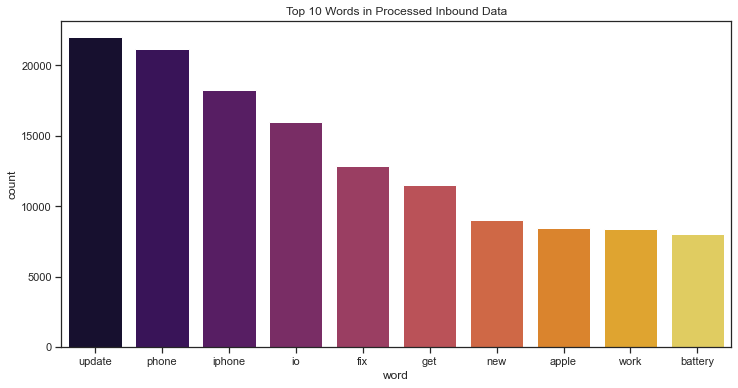

In [6]:
# Vectorizing the data with Count Vectorizer
bagofwords = CountVectorizer(min_df = 5).fit(string_processed_inbound)
inbound_cv = bagofwords.transform(string_processed_inbound)

# For visualizing top 10
def top10_bagofwords(data, output_name, title):
    ''' Taking as input the data and plots the top 10 words based on counts in this text data'''
    bagofwords = CountVectorizer()
    # Output will be a sparse matrix
    inbound = bagofwords.fit_transform(data)
    # Inspecting of often contractions and colloquial language is used
    word_counts = np.array(np.sum(inbound, axis=0)).reshape((-1,))
    words = np.array(bagofwords.get_feature_names())
    words_df = pd.DataFrame({"word":words, 
                             "count":word_counts})
    words_rank = words_df.sort_values(by="count", ascending=False)
    # words_rank.to_csv('words_rank.csv') # Storing it in a csv so I can inspect and go through it myself
    words_rank.head()
    # Visualizing top 10 words
    plt.figure(figsize=(12,6))
    sns.barplot(words_rank['word'][:10], words_rank['count'][:10].astype(str), palette = 'inferno')
    plt.title(title)
    
    # Saving
    plt.savefig(f'visualizations/{output_name}.png')
    
    plt.show()


top10_bagofwords(string_processed_inbound, 'initial_frequencies', 'Top 10 Words in Processed Inbound Data')

我主要使用计数向量器来查看在特定数据集中出现的前10个单词，并在这里进行可视化。

从上面的可视化中，我可以看出大部分的客户查询都是关于手机的，特别是iOS和电池修复。我们也看到“谢谢”排名相当高，这是一件好事，因为它可能表示感激（这表示我的聊天机器人的结束意图）。"Hi"（排名44）和"hey"（排名25）被分类为问候意图，看到它们出现的次数很多，这是一件好事。现在事情看起来很有希望，但我们在实际开始聚类之前无法看到质量。

### 2.TFIDF

In [7]:
tfidf = TfidfVectorizer(min_df=5, ngram_range = (1,3))
# Storing tfidf data and transforming them into sparse matrices
inbound_tfidf = tfidf.fit_transform(string_processed_inbound)
inbound_tfidf

<77175x34110 sparse matrix of type '<class 'numpy.float64'>'
	with 1259391 stored elements in Compressed Sparse Row format>

## Pretrained word embeddings

词袋模型丢失了许多细微之处，如词序。这就是我将尝试这些其他文本向量化方法的原因。现在我们有了更有效的方法，特别是因为我想在这些向量中编码的是意图集群。

### 3. GloVe
我将使用多种词嵌入方法以不同的方式向量化我的文本，然后测试哪种词嵌入方法最好，首先从GloVe词嵌入开始。GloVe是一种获取词向量表示的无监督学习算法。

Gensim限制了预训练的词嵌入，并有一种特殊的数据格式，你可以基本上将其加载为numpy数组。

免责声明：我不会使用这个，因为我的聚类算法只在每条推文是一个点时才工作，而这是一个词转换器。我将这部分留在我的笔记本中作为进度记录。

Useful sources for this step: 
* [Guide to word to vec word embeddings](https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92)
* Zeugma Docs
    * https://pypi.org/project/zeugma/0.41/
    * https://github.com/nkthiebaut/zeugma

## 4. Doc2Vec
由于这是我将用于管道的主要嵌入方法，我在下一个笔记本中展示了我如何利用这个嵌入方法。

## 5. Hugging Face
这是一家专注于自然语言处理的初创公司。我探索了他们的编码器。

BERT并不是一个很好的选择，因为其中的大部分内容是使用维基百科数据训练的。

我不确定doc2vec是基于什么训练的，我认为如果我能找到基于Twitter的词嵌入，我的结果会更好！

## 6. Fast-text 


# Scaling the Data

在我们进行聚类之前，让我们首先制作数据集的缩放版本，这对于基于距离的聚类方法会很有帮助。一般来说，这些向量实际上不需要缩放，但这可能有助于计算目的。我只对我的计数向量化和tfidf向量化数据进行这样的处理，而不是对具有更有意义的词嵌入的数据进行处理。

In [8]:
# This is the data we have so far, they are stored in CSR compressed format
inbound_cv, inbound_tfidf

(<77175x4893 sparse matrix of type '<class 'numpy.int64'>'
 	with 768941 stored elements in Compressed Sparse Row format>,
 <77175x34110 sparse matrix of type '<class 'numpy.float64'>'
 	with 1259391 stored elements in Compressed Sparse Row format>)

In [9]:
# Fitting and transforming to create standard scaled versions of my data
inbound_cv_ma = MaxAbsScaler().fit_transform(inbound_cv)
inbound_tfidf_ma = MaxAbsScaler().fit_transform(inbound_cv)

inbound_cv_ma, inbound_tfidf_ma

(<77175x4893 sparse matrix of type '<class 'numpy.float64'>'
 	with 768941 stored elements in Compressed Sparse Row format>,
 <77175x4893 sparse matrix of type '<class 'numpy.float64'>'
 	with 768941 stored elements in Compressed Sparse Row format>)

**训练考虑：**因为我将在项目的下一部分训练神经网络，所以我的目标是拥有大约10个意图（通过EDA，取决于数据中自然意图的实际数量）。对于这10个意图中的每一个，我想为每个意图提供大约1000个示例。我选择这个特定的数字是因为我希望每个意图的例子分布均匀，这样我就不会出现类不平衡，而且我的神经网络可以相对较好地对这十个类进行分类。


考虑到这一点，让探索开始吧！

我将尝试在我的数据上使用聚类方法和主题建模来提取主要主题并手动标记这些聚类。

如果我的数据都在同一类型的客户服务领域，我会取得更大的成功，而且我很小心地确保推特-苹果的数据是这样的。这样，我在下一个笔记本电脑中的模型将捕捉到意图分类的细微差别。一般来说，机器人会擅长用它所训练的语言谈论话题。

我知道，使用集群，您不能期望您的模型以预先集群的方式对数据进行集群。这是一个整体算法。我希望他们能神奇地将意图轻松地聚集在一起，然而现在可能就那么容易了！我们拭目以待。

## <font color='blue'>1. K Means</color>
我对单词向量进行聚类的第一种方法是K-Means，它往往在Blob上表现良好。

缺点是它非常慢，而且很难选择K的值——我甚至不知道数据中有多少意图。这就是为什么我从K的较大跳跃开始，以获得哪一个表现最好的更高层次的想法，然后我深入研究，最终决定什么K最适合在我的数据集中找到最佳意图数量。

## 1.1. 我的TFIDF和计数矢量化数据的K-Means
首先，我对TFIDF和计数矢量化数据进行了聚类。老实说，我不会真的期望它能带来好的结果，所以我不会花很多精力在这两个方面进行实际的聚类。但值得一试，以证明一种较老且次优的方法。

In [10]:
# Vectorized data
vectorized_data = {'inbound_cv_ma': inbound_cv_ma, 'inbound_tfidf_ma': inbound_tfidf_ma}
# Briefly showing the contents of i and j
for i,j in enumerate(vectorized_data.items()): print(i,j);

0 ('inbound_cv_ma', <77175x4893 sparse matrix of type '<class 'numpy.float64'>'
	with 768941 stored elements in Compressed Sparse Row format>)
1 ('inbound_tfidf_ma', <77175x4893 sparse matrix of type '<class 'numpy.float64'>'
	with 768941 stored elements in Compressed Sparse Row format>)


我正在对这里的所有数据运行我的整个K-Means。我正在对n_clusters进行超参数优化。第一个进度条是它如何处理数据集，第二个是它完成了所有n_clusters。

在缩放之前，我花了三个小时在10到100的10次迭代中对这两种数据类型应用K-Means。幸运的是，在我攀登之后，它训练得更快了。

我使用Python的序列化包Pickle将结果存储在这个单元格下面，这样我就不必再运行它了！

In [11]:
%%time
# My grand dictionaries that will store all my results
wcss_grand = {}
labels_grand = {}
silhouette_scores_grand = {}
# n_clusters = [10,20,30,40,50,60,70,80,90,100]
n_clusters = [10]

# Iterating through all the differently embedded data
for i,j in tqdm(enumerate(vectorized_data.items())): 
    name = j[0] # Here j[0] is the name of the dataset
    dataset = j[1] # And j[1] is the actual data
    
    # I store my metrics at these following lists
    wcss = []
    labels = []
    silhouette_scores = []
    
    # Looping through values of k
    for k in tqdm(n_clusters):    
        print(f'Currently fitting {name} with {k} clusters... Please wait')
        
        # Initializing with k-means++ ensures that you get don’t fall into the random initialization trap.
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state = 10)
        kmeans.fit(dataset)
        wcss.append(kmeans.inertia_)
        
        # Getting the silhouette score
        labels.append(kmeans.labels_)
        silhouette_scores.append(silhouette_score(dataset, kmeans.labels_))
        
        # Saving the models
        filename = f'models/kmeans/{name}-{k}neighbors.sav'
        joblib.dump(kmeans, filename)
        
    # Updating grand dictionary
    wcss_grand[name + '_wcss'] = wcss
    labels_grand[name + '_labels'] = labels
    silhouette_scores_grand[name + '_silhouettes'] = silhouette_scores

# Saving all my results
with open('objects/wcss_grand.pkl', 'wb') as handle:
    pickle.dump(wcss_grand, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('objects/labels_grand.pkl', 'wb') as handle:
    pickle.dump(labels_grand, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('objects/silhouette_scores_grand.pkl', 'wb') as handle:
    pickle.dump(silhouette_scores_grand, handle, protocol=pickle.HIGHEST_PROTOCOL)

<timed exec>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

<timed exec>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

Currently fitting inbound_cv_ma with 10 clusters... Please wait


<timed exec>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

Currently fitting inbound_tfidf_ma with 10 clusters... Please wait
CPU times: user 4min 22s, sys: 1min 2s, total: 5min 25s
Wall time: 4min 31s


### Reading back in the results

In [12]:
# Storing it into objects I can use in this notebook

with open('objects/wcss_grand.pkl', 'rb') as handle:
    wcss_grand = pickle.load(handle)
with open('objects/labels_grand.pkl','rb') as handle:
    labels_grand = pickle.load(handle)
with open('objects/silhouette_scores_grand.pkl','rb') as handle:
    silhouette_scores_grand = pickle.load(handle)

## 寻找最佳K-Means模型

我正在画一个肘部图，看看是否有一个清晰的肘部，希望我能找到，但可能性不大。

我首先对**count个矢量化的**数据进行处理，然后对**tfidf**矢量化的数据进行处理：

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

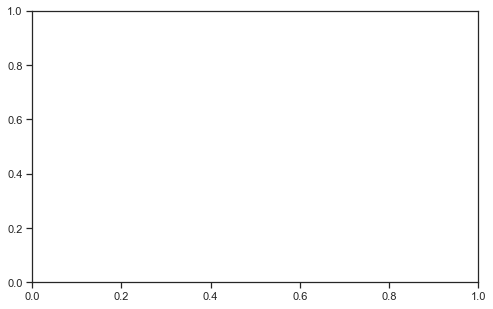

In [13]:
# Elbow Plot count vectorized
plt.figure(figsize=(8,5))
plt.plot(range(10, 101, 10), wcss_grand['inbound_cv_ma_wcss'], color = 'magenta')
plt.title('Elbow Method (Count Vectorized)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Elbow Plot tfidf
plt.figure(figsize=(8,5))
plt.plot(range(10, 101, 10), wcss_grand['inbound_tfidf_ma_wcss'], color = 'magenta')
plt.title('Elbow Method (TFIDF)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silouette Plot count vectorized
plt.figure(figsize=(8,5))
plt.plot(range(10, 101, 10), silhouette_scores_grand['inbound_cv_ma_silhouettes'], color = 'red')
plt.title('Silhouette Method (Count Vectorized)')
plt.xlabel('Silhouette Score')
plt.ylabel('WCSS')
plt.show()

# Silouette Plot tfidf
plt.figure(figsize=(8,5))
plt.plot(range(10, 101, 10), silhouette_scores_grand['inbound_tfidf_ma_silhouettes'], color = 'red')
plt.title('Silhouette Method (TFIDF)')
plt.xlabel('Silhouette Score')
plt.ylabel('WCSS')
plt.show()

我们看到这些图在TFIDF和计数矢量化数据之间并没有太大变化，这进一步说明了我上面的说法，即它们并不是最有用的。

## 用t-SNE可视化我的集群

我尝试不同的颜色贴图并选择一个，这样更容易区分簇。

Available sequential colormaps:

```['viridis', 'plasma', 'inferno', 'magma', 'cividis']```

```['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']```

Available qualitative colormaps:
```['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']```

In [14]:
# Current data
inbound_cv_ma.shape, inbound_tfidf_ma.shape

((77175, 4893), (77175, 4893))

t-SNE是一个概率模型，所以这需要一些时间，特别是因为我们有大约80k行。

In [15]:
%time
# Instantiate t-SNE
tsne = TSNE(n_components=2, random_state=1, n_jobs=-1)

# Fit t-SNE
inbound_cv_ma_tsne = tsne.fit_transform(inbound_cv_ma)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


KeyboardInterrupt: 

In [ ]:
# Plotting my visualization for each of my n_neighbors with my count vectorized data

for k in range(10,101,10):
    # Getting the right K-Means cluster labels.
    labels = joblib.load(f'models/kmeans/inbound_cv_ma-{str(k)}neighbors.sav').labels_
    
    # Visualize high-dimensional data
    plt.figure(figsize=(13,12))
    plt.scatter(inbound_cv_ma_tsne[:,0], inbound_cv_ma_tsne[:,1], s=20, c = labels, cmap = 'magma')
    plt.title(f'2-D t-SNE Representation of my Count Vectorized Inbound data with {k} Clusters')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()

一开始我以为我真的看不到任何星团！但请记住，我有这么多数据点，所以我必须把这些集群做得很大。很酷的绘图，尽管我们的高维数据的2D表示不会非常准确，但我们还远远没有看到清晰的聚类！

我不希望它有太大的不同，但让我们看看我的TFIDF数据的相同图。

In [ ]:
%time
# Instantiate t-SNE
tsne = TSNE(n_components=2, random_state=1, n_jobs=-1)

# Fit t-SNE
inbound_tfidf_ma_tsne = tsne.fit_transform(inbound_tfidf_ma)

In [ ]:
# Plotting my visualization for each of my n_neighbors with my tfidf data

for k in range(10,101,10):
    # Getting the right K-Means cluster labels.
    labels = joblib.load(f'models/kmeans/inbound_tfidf_ma-{str(k)}neighbors.sav').labels_
    
    # Visualize high-dimensional data
    plt.figure(figsize=(13,12))
    plt.scatter(inbound_tfidf_ma_tsne[:,0], inbound_tfidf_ma_tsne[:,1], s=20, c = labels, cmap = 'magma')
    plt.title(f'2-D t-SNE Representation of my TFIDF Inbound data with {k} Clusters')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()

果不其然，这些看起来真的很像计数矢量化集群！让我们继续讨论单词嵌入集群，我认为这更有趣。

## 1.2. K-Means for my Doc2Vec data

请注意，我没有故意缩放d2v数据，因为我不想扭曲预训练模型创建的距离。

In [ ]:
# Vectorized data
vectorized_data = {'inbound_cv_d2v': inbound_d2v}
# Briefly showing the contents of i and j
for i,j in enumerate(vectorized_data.items()): print(i,j);

In [ ]:
# My d2v dictionaries that will store all my results
wcss_d2v = {}
labels_d2v = {}
silhouette_scores_d2v = {}
n_clusters = [10,20,30,40,50,60,70,80,90,100]

# Iterating through all the differently embedded data
for i,j in tqdm(enumerate(vectorized_data.items())): 
    name = j[0] # Here j[0] is the name of the dataset
    dataset = j[1] # And j[1] is the actual data
    
    # I store my metrics at these following lists
    wcss = []
    labels = []
    silhouette_scores = []
    
    # Looping through values of k
    for k in tqdm(n_clusters):    
        print(f'Currently fitting {name} with {k} clusters... Please wait')
        
        # Initializing with k-means++ ensures that you get don’t fall into the random initialization trap.
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state = 10)
        kmeans.fit(dataset)
        wcss.append(kmeans.inertia_)
        
        # Getting the silhouette score
        labels.append(kmeans.labels_)
        silhouette_scores.append(silhouette_score(dataset, kmeans.labels_))
        
        # Saving the models
        filename = f'models/kmeans/{name}-{k}neighbors.sav'
        joblib.dump(kmeans, filename)
        
    # Updating d2v dictionary
    wcss_d2v[name + '_wcss'] = wcss
    labels_d2v[name + '_labels'] = labels
    silhouette_scores_d2v[name + '_silhouettes'] = silhouette_scores

# Saving all my results, now with a d2v tag
with open('objects/wcss_d2v.pkl', 'wb') as handle:
    pickle.dump(wcss_d2v, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('objects/labels_d2v.pkl', 'wb') as handle:
    pickle.dump(labels_d2v, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('objects/silhouette_scores_d2v.pkl', 'wb') as handle:
    pickle.dump(silhouette_scores_d2v, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Reading back in the results.

In [ ]:
# Storing it into objects I can use in this notebook

with open('objects/wcss_d2v.pkl', 'rb') as handle:
    wcss_d2v = pickle.load(handle)
with open('objects/labels_d2v.pkl','rb') as handle:
    labels_d2v = pickle.load(handle)
with open('objects/silhouette_scores_d2v.pkl','rb') as handle:
    silhouette_scores_d2v = pickle.load(handle)

Here are my plots:

In [ ]:
# Elbow Plot d2v
plt.figure(figsize=(8,5))
plt.plot(range(10, 101, 10), wcss_d2v['inbound_cv_d2v_wcss'], color = 'magenta')
plt.title('Elbow Method (Doc2Vec)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silouette Plot d2v
plt.figure(figsize=(8,5))
plt.plot(range(10, 101, 10), silhouette_scores_d2v['inbound_cv_d2v_silhouettes'], color = 'red')
plt.title('Silhouette Method (Doc2Vec)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Great, now we see that we have a slightly higher silhouette score which isn't negative now. It looks like K = 20 would be the best in this case as it has the highest silhouette score and there is sort of an elbow in the elbow plot, definitely more than at 80 clusters where it seems to be completely smooth.

In [ ]:
%time
# Instantiate t-SNE
tsne = TSNE(n_components=2, random_state=1, n_jobs=-1)

# Fit t-SNE
inbound_d2v_tsne = tsne.fit_transform(inbound_d2v)

In [ ]:
# Plotting my visualization for each of my n_neighbors, now with Doc2Vec embedded data

for k in range(10,101,10):
    # Getting the right K-Means cluster labels.
    labels = joblib.load(f'models/kmeans/inbound_cv_d2v-{str(k)}neighbors.sav').labels_
    
    # Visualize high-dimensional data
    plt.figure(figsize=(13,12))
    plt.scatter(inbound_d2v_tsne[:,0], inbound_d2v_tsne[:,1], s=20, c = labels, cmap = 'magma')
    plt.title(f'2-D t-SNE Representation of my Doc2Vec Inbound data with {k} Clusters')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()

基于t-SNE图很难判断，因此，我将在后面的部分通过实际查看标签来评估它是如何聚集的！

## <font color = 'blue'>2. LDA (Latent Dirichlet Allocation) </color>
我的第二种聚类方法是LDA主题建模。它基本上会获取您的数据并将其拆分为多个主题。我的目标仍然是集群，但通过这种方法，我希望获得更有用、更独特的主题。


Useful articles:
* https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
* https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05

还有一些新的、基于深度学习的方法，称为LDA2Vec，也可能很有兴趣探索。

然而，由于比例的变化，我将把这一步作为未来的一步。

In [ ]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

In [ ]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
with open(LDAvis_data_filepath, 'w') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

出于时间限制的考虑，我决定不使用DBScan，因为它们将获得类似于K-Means的聚类结果。我也可以使用高斯混合模型或Heirarchical聚类来实现这个聚类结果。

## 发现并可视化集群之间的意图差异

我把我所有的模型都保存在这个名为文件夹的目录中的一个文件夹中。我所要做的就是为该模型选择一个超参数设置，并可视化这些聚类中的单词。

In [ ]:
processed_inbound

我认为查看集群中的前10个单词非常有用，可以很好地了解集群中的意图！

### Using scattertext from the spaCy universe for EDA
This [kernel](https://www.kaggle.com/psbots/customer-support-meets-spacy-universehttps://www.kaggle.com/psbots/customer-support-meets-spacy-universe) showed me what spaCy's scattertext tool is capable of doing! So I wanted to do it myself as well to hopefully get useful insights.

正如文档中所说，散点文本是“一种在中小型语料库中找到区别术语的工具，并用不重叠的术语标签在性感的交互式散点图中呈现它们。”

这对于比较我在以下笔记本中的意图集群也非常有用。

In [ ]:
!ls models/kmeans

In [ ]:
labels = joblib.load(f'models/kmeans/inbound_cv_d2v-10neighbors.sav').labels_

# Scattertext for cluster evaluation

In [ ]:
corpus = st.CorpusFromParsedDocuments(love['Text'], category_col = 
                             parsed_col = 'parsed').build()

In [ ]:
# html = st.produce_scattertext_explorer(corpus,
#           category='British_Airways',
#           category_name='British Airways',
#           not_category_name='American Airlines',
#           width_in_pixels=600,
#           minimum_term_frequency=10,
#           term_significance = st.LogOddsRatioUninformativeDirichletPrior(),
#           )

In [ ]:
# uncomment this cell to load the interactive scattertext visualisation
# filename = "americanAir-vs-britishAirways.html"
# open(filename, 'wb').write(html.encode('utf-8'))
# IFrame(src=filename, width = 800, height=700)

In [ ]:
### Using scattertext from the spaCy universe for EDA
This [kernel](https://www.kaggle.com/psbots/customer-support-meets-spacy-universehttps://www.kaggle.com/psbots/customer-support-meets-spacy-universe) showed me what spaCy's scattertext tool is capable of doing! So I wanted to do it myself as well to hopefully get useful insights.

As said in the docs, scatter-text is "a tool for finding distinguishing terms in small-to-medium-sized corpora, and presenting them in a sexy, interactive scatter plot with non-overlapping term labels."

This will be very useful for comparing my intent clusters in the following notebook as well.

corpus = st.CorpusFromParsedDocuments(processed_inbound,
                             parsed_col = 'parsed').build()

# html = st.produce_scattertext_explorer(corpus,
#           category='British_Airways',
#           category_name='British Airways',
#           not_category_name='American Airlines',
#           width_in_pixels=600,
#           minimum_term_frequency=10,
#           term_significance = st.LogOddsRatioUninformativeDirichletPrior(),
#           )

# uncomment this cell to load the interactive scattertext visualisation
# filename = "americanAir-vs-britishAirways.html"
# open(filename, 'wb').write(html.encode('utf-8'))
# IFrame(src=filename, width = 800, height=700)def top10_bagofwords(data):
    ''' Taking as input the data and plots the top 10 words based on counts in this text data'''
    bagofwords = CountVectorizer()
    inbound = bagofwords.fit_transform(data)
    inbound # Output will be a sparse matrix
    # Inspecting of often contractions and colloquial language is used
    word_counts = np.array(np.sum(inbound, axis=0)).reshape((-1,))
    words = np.array(bagofwords.get_feature_names())
    words_df = pd.DataFrame({"word":words, 
                             "count":word_counts})
    words_rank = words_df.sort_values(by="count", ascending=False)
    # words_rank.to_csv('words_rank.csv') # Storing it in a csv so I can inspect and go through it myself
    words_rank.head()
    # Visualizing top 10 words
    plt.figure(figsize=(12,8))
    sns.barplot(words_rank['word'][:10], words_rank['count'][:10].astype(str), color = 'salmon')
    plt.title('Top 10 Most Common Words in My Data')
    plt.show()

# 我的方法：启发式意图分布探索
我需要了解我的Twitter数据中有多少真实的意图。通过关键词来做可能证明是一个很好的基线方法。我基于这个想法，通过尝试最小化意图交集来进行启发式的意图聚类。我尝试用这种方法来归纳出最为独特和_互斥的_意图集合，以便机器人能够被训练区分这些意图。

我受到了看到其他解决方案的启发，比如cortex的实现，他们为每个意图制作了一个“语义指纹”。显然，那些细节没有分享，但这足以让我尝试想出自己的解决方案。最初，我打算从聚类中分出来，并尝试手动挑选1000个例子，但这并不是一个明智的主意，而且非常劳动密集。

这个笔记本是我获取意图分类训练数据的方式。

In [13]:
import pandas as pd
print(f'pandas: {pd.__version__}')
import numpy as np
print(f'numpy: {np.__version__}')
# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
# Making my visualizations pretty
sns.set_style('whitegrid')
# Combination exploration
import itertools
import yaml

# Loading back processed data
processed = pd.read_pickle('objects/processed.pkl')
print(f'\ninbound:\n{processed.head()}')

pandas: 1.2.3
numpy: 1.21.0

inbound:
                                    Processed Inbound  \
0   [new, update, i️, make, sure, download, yester...   
6   [hey, anyone, else, upgraded, io, issue, capit...   
12  [hello, internet, someone, explain, symbol, ke...   
13  [get, screenshot, say, iphonex, reserve, email...   
15  [thank, update, phone, even, slow, barely, wor...   

                                         Real Inbound  \
0   @AppleSupport The newest update. I️ made sure ...   
6   Hey @AppleSupport and anyone else who upgraded...   
12  Hello, internet. Can someone explain why this ...   
13  @AppleSupport I’ve got a screenshot saying my ...   
15  Thank you @AppleSupport I updated my phone and...   

                                        Real Outbound  
0   @115854 Lets take a closer look into this issu...  
6   @115856 Hey, let's work together to figure out...  
12  @115861 You're in the right place; we'll do al...  
13  @115863 Go ahead and send us a DM please. Let ..

## 简短的关键词搜索EDA
使用这个工具来查看推文。根据关键词来过滤推文。

In [3]:
# Search by keywords (single keyword filter)
keyword = 'update'

# Seeing what the processed Tweets look like
filt = [(i,j) for i,j in enumerate(processed['Processed Inbound']) if keyword in j]
filtered = processed.iloc[[i[0] for i in filt]]
print(f'{len(filtered)} Tweets contain the keyword {keyword}')
filtered

20190 Tweets contain the keyword update


,Processed Inbound,Real Inbound,Real Outbound
0,"[new, update, i️, make, sure, download, yester...",@AppleSupport The newest update. I️ made sure ...,@115854 Lets take a closer look into this issu...
15,"[thank, update, phone, even, slow, barely, wor...",Thank you @AppleSupport I updated my phone and...,"@115864 We'd like to help, but we'll need more..."
19,"[need, software, update, urgently, battery, la...",@AppleSupport I need the software update urgen...,@115865 Hi there! What type of device are we w...
25,"[hey, last, time, download, update, freak, pho...",Hey @115858! Last time I downloaded an update ...,@115869 We're here to help. Meet us in DM and ...
38,"[iphone, yes, io, checked, update, none, avail...","@AppleSupport iPhone 6, yes ios11. Checked for...","@116102 To make sure, is iOS 11.1 showing here..."
...,...,...,...
106624,"[dear, fuck, wish, iphone, would, stop, crash,...",Dear @115858 I fucking wish my iPhone 7 would ...,@823495 We know it's important for your iPhone...
106630,"[im, upset, update, every, time, type, anythin...","im so upset over this @115858 update, every ti...",@485591 We completely understand being upset a...
106634,"[home, button, work, phone, battery, last, lit...",@115858 My home button does not work. My phone...,@823651 We want your iPhone to work as it shou...
106636,"[whenever, new, iphone, get, launch, old, mode...",@115858 why is it whenever a new iphone gets l...,@823679 Thanks for reaching out. We know how i...


In [19]:
[*filtered['Real Inbound']]

['Come on @AppleSupport #ios11.1  Same bug as before. Numbers disappear when entering info. Video below. #iosproblems https://t.co/eKirAn2Mam',
 "@115858 Thank you for making me learn the hard way. Removed all my financial info from my profile so I can't be robbed again.",
 '@AppleSupport I am from the US but I live in China. Is it possible to have my iPhone/Mac iCloud linked to my Chinese info (bank, address), and separate Apple ID linked to my U.S. info (bank, address)?..Want to keep my iCloud storage in China but use App Store/Apple music from US',
 '@AppleSupport Please give me some info on Apple Pay on ios11 on iPhone 7 India support. Thanks in advance.',
 '@AppleSupport The connection is always correct, song info is displayed. 9 out of 10 times closing Waze is solving the issue and the audio is streaming again.',
 '@AppleSupport I am using 11.1.2.  The controls/info are there, but cannot be seen (podcast controls/number pad for code entry respond when touched--assuming where the 

# 我的意图

以下这个单元格代表了我发现意图的过程。最终，下面的所有内容都是为了决定这个字典的选择，以及随后创建我的训练数据。当我意识到我可以将其与命名实体识别结合使用时，它大大减少了。

你会注意到它并不包含所有内容，那是因为有些意图不在我的训练数据中 - 它们必须手动创建。例如，问候的例子：这个训练数据不会仅仅包含带有'hi'的推文，它们几乎总是包含多个意图。

In [11]:
# 事后意图：我找到与意图相关的关键词，并基于这些关键词进行搜索
# 版本1 - 初始模型：创建一个字典来存储意图和预定义的响应

intents = {
    "Greeting": ["Hi there!", "Hello"],
    "Closing": "Thanks for talking",
    "Promotion": "",
    "Scenarios": {
        "Last payment": "",
        "Account details": "",
        "Account confirmation": "",
    },
    "Location": "",
}

# 版本2 - 仅用于显示进度
intents = {
    "greeting": ["hi", "hello", "hey", "yo"],
    "app": ["app", "application"],
    "iphone": ["iphone", "i phone"],
    "icloud": ["icloud", "i cloud"],
    "ios": ["io"],
    "battery": ["battery"],
    "watch": ["watch"],
    "mac": ["mac", "macbook", "laptop", "computer"],
    "update": ["update"],
    "troubleshooting": ["problem", "trouble", "error"],
    "settings": ["settings", "setting"],
    "music": ["music", "song", "playlist"],
    "payment": ["credit", "card", "payment", "pay"],
    "bug": ["bug"],
    "watch": ["tv", "show"],
    "network": ["internet", "connection", "network"],
}

# 需要列表中包含所有单词的意图（替代过滤方法）
intents_all = {"ios update": ["io", "update"], "app update": ["app", "update"]}

# Version 3
intents = {
    "update": ["update"],
    "battery": ["battery", "power"],
    "forgot_password": ["password", "account", "login"],
    "repair": ["repair", "fix", "broken"],
    "payment": ["credit", "card", "payment", "pay"],
}

# Storing it to YAML file
with open("objects/intents.yml", "w") as outfile:
    yaml.dump(intents, outfile, default_flow_style=False)

print("INTENTS FOR KEYWORD EDA BELOW:\n ------------------------")
for i in intents.items():
    print("Intent: {} \n   Keywords: {}".format(i[0], " + ".join(i[1])))

INTENTS FOR KEYWORD EDA BELOW:
 ------------------------
Intent: greeting 
   Keywords: hi + hello + hey + yo
Intent: app 
   Keywords: app + application
Intent: iphone 
   Keywords: iphone + i phone
Intent: icloud 
   Keywords: icloud + i cloud
Intent: ios 
   Keywords: io
Intent: battery 
   Keywords: battery
Intent: watch 
   Keywords: tv + show
Intent: mac 
   Keywords: mac + macbook + laptop + computer
Intent: update 
   Keywords: update
Intent: troubleshooting 
   Keywords: problem + trouble + error
Intent: settings 
   Keywords: settings + setting
Intent: music 
   Keywords: music + song + playlist
Intent: payment 
   Keywords: credit + card + payment + pay
Intent: bug 
   Keywords: bug
Intent: network 
   Keywords: internet + connection + network


### 我制作的有用函数。这将对意图探索性分析非常有用。

In [8]:
# 三种不同的方式根据关键词过滤推文
# 1.
def get_key_tweets(series, keywords):
    ''' 接受关键词列表作为输入，并输出至少包含其中一个关键词的推文 '''
    keyword_tweets = []
    for tweet in series:
        # Want to check if keyword is in tweets
        for keyword in keywords:
            if keyword in tweet:
                keyword_tweets.append(tweet)
    return keyword_tweets

# 2. 制作一个过滤器，用于筛选需要包含所有关键词的推文
def all_key_tweets(series, keywords):
    ''' 接受关键词列表作为输入，并输出包含所有这些关键词的推文 '''
    keyword_absent_tweets = []
    for tweet in series:
        # Want to check if keyword is not in tweets
        if all(item in tweet for item in keywords):
            keyword_absent_tweets.append(tweet)
    return keyword_absent_tweets

# 3. 制作一个过滤器，用于筛选不包含任何关键词的推文
def key_absent_tweets(series, keywords):
    ''' 接受关键词列表作为输入，并输出不包含任何这些关键词的推文 '''
    keyword_absent_tweets = []
    for tweet in series:
        # Want to check if keyword is not in tweets
        if not any(item in tweet for item in keywords):
            keyword_absent_tweets.append(tweet)
    return keyword_absent_tweets

# Getting a list of all my keywords so far
all_keywords = []
for keywords in intents.values():
    for keyword in keywords:
        all_keywords.append(keyword)      
        

def only_key_tweets(series, keywords):
    ''' Uses the all_keywords '''
    kept = list()
    for tweet in series:
        # Check
        if all(elem in tweet for elem in keywords):
            kept.append(tweet)
    return pd.Series(kept)
        
def to_set(l):
    ''' 为了将推文制作成集合以检查交集，我们需要通过将其转换为元组来使它们不可变，因为集合只接受不可变的元素 '''
    return set([tuple(row) for row in l])


### Intent 可视化

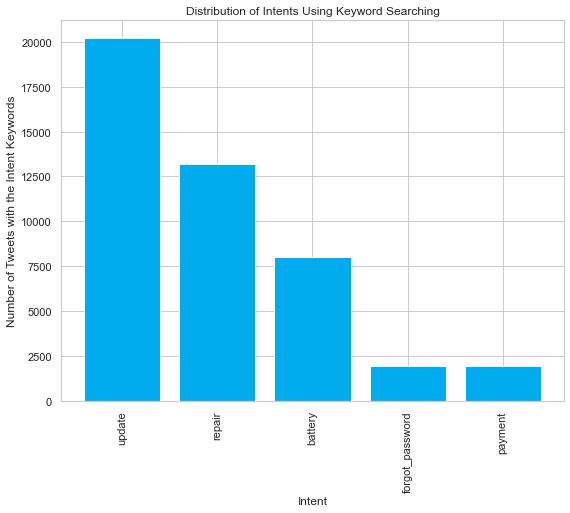

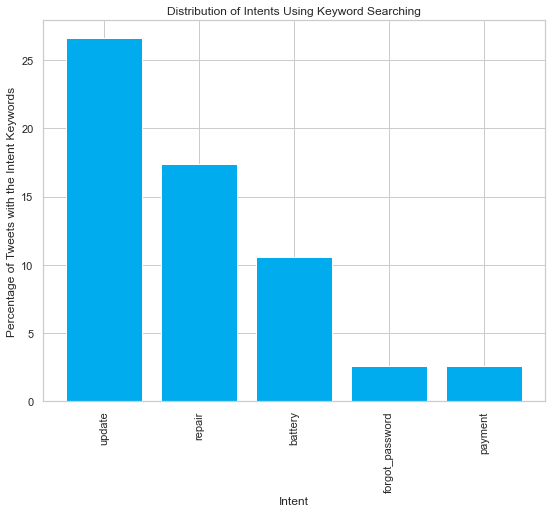

In [22]:
# Using the function above to visualize the distribution of intents in my dataset

intent_lengths = [
    len(get_key_tweets(processed["Processed Inbound"], intents[intent]))
    for intent in intents.keys()
]
keyword = pd.DataFrame(
    {"intents": list(intents.keys()), "intent_lengths": intent_lengths}
).sort_values("intent_lengths", ascending=False)

# Visualization
plt.figure(figsize=(9, 7))
plt.bar(keyword["intents"], keyword["intent_lengths"], color="#00acee")
plt.title("Distribution of Intents Using Keyword Searching")
plt.xlabel("Intent")
plt.xticks(rotation=90)
plt.ylabel("Number of Tweets with the Intent Keywords")
plt.show()

# Proportions visualization
plt.figure(figsize=(9, 7))
plt.bar(keyword["intents"], keyword["intent_lengths"] * 100 / 75879, color="#00acee")
plt.title("Distribution of Intents Using Keyword Searching")
plt.xlabel("Intent")
plt.xticks(rotation=90)
plt.ylabel("Percentage of Tweets with the Intent Keywords")
# Saving
plt.savefig("visualizations/intent_distribution_keyword.png")
plt.show()

In [23]:
# Seeing precise numeric counts
keyword

,intents,intent_lengths
0,update,20190
3,repair,13208
1,battery,7986
2,forgot_password,1934
4,payment,1915


从这里看来，我们似乎不会有足够的数据来为最后两个意图各得到1000个实例，但这没关系，因为我或许可以稍后复制它们。

我还做了一个替代的过滤器，用于计算至少包含一个问号的推文数量。在这次探索中，我发现在总数75879条推文中，有27373条至少包含1个问号（占36.1%）。

### 组合探索
在这里，我想看看不同类别之间有多少推文重叠。如果意图之间的重叠太多，这意味着我们可以为那条特定的推文标记两个意图。我认为这仍然是可行的，尽管这意味着我们需要看看如何回复双重意图。

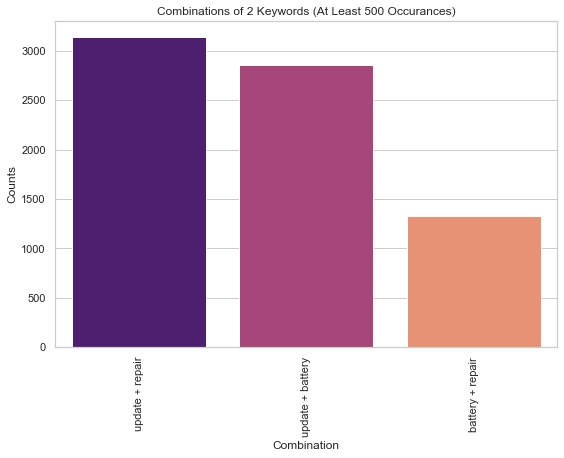

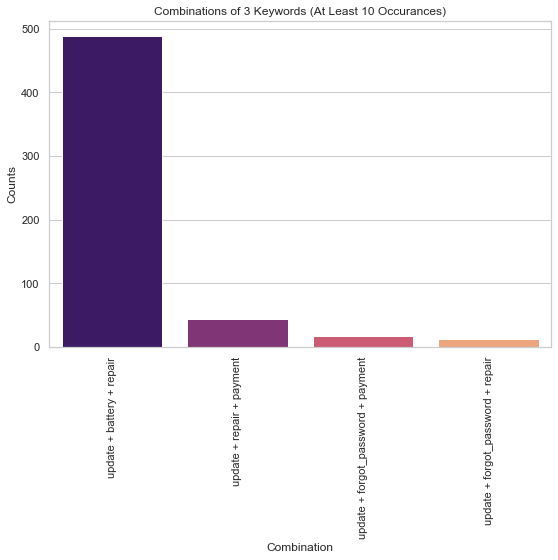

Not enough 4-combinations (Thres = 5)
Not enough 5-combinations (Thres = 5)


<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

In [9]:
# 初始化所有组合出现次数的最小阈值
thres = [500, 10, 5, 5]

# 意图推文包含所有关键词，并且作为集合的值包含所有包含该关键词的推文
intent_tweets = {}
for key in intents.keys():
    intent_tweets[key] = to_set(
        get_key_tweets(processed["Processed Inbound"], intents[key])
    )

# 遍历所有配对，并获取配对之间的推文交集数量
keyword_overlaps = {}

# 两个意图的组合

# 每个i返回一个包含r长度对的元组，在这个例子中r为2
for i in list(itertools.combinations(list(intents.keys()), 2)):
    a = to_set(intent_tweets[i[0]])
    b = to_set(intent_tweets[i[1]])
    # Inserting pair to dictionary
    keyword_overlaps[f"{i[0]} + {i[1]}"] = len(a.intersection(b))

# 筛选出重要的组合，我定义的重要的标准是出现次数大于100
combs = []
counts = []
for i in keyword_overlaps.items():
    if i[1] > thres[0]:
        combs.append(i[0])
        counts.append(i[1])

# Visualizing as well
v = pd.DataFrame({"Combination": combs, "Counts": counts}).sort_values(
    "Counts", ascending=False
)
plt.figure(figsize=(9, 6))
sns.barplot(x=v["Combination"], y=v["Counts"], palette="magma")
plt.title(f"Combinations of 2 Keywords (At Least {thres[0]} Occurances)")
plt.xticks(rotation=90)
plt.show()

# 三个意图的组合
keyword_overlaps = {}

try:
    # Each i returns a tuple containing a pair of length r, which in this case is 3
    for i in list(itertools.combinations(list(intents.keys()), 3)):
        a = to_set(intent_tweets[i[0]])
        b = to_set(intent_tweets[i[1]])
        c = to_set(intent_tweets[i[2]])
        # Inserting pair to dictionary
        keyword_overlaps[f"{i[0]} + {i[1]} + {i[2]}"] = len(
            a.intersection(b).intersection(c)
        )

    # Filtering to just the significant ones, which I define as greater than 100
    combs = []
    counts = []
    for i in keyword_overlaps.items():
        if i[1] > thres[1]:
            combs.append(i[0])
            counts.append(i[1])

    # Visualizing as well
    v = pd.DataFrame({"Combination": combs, "Counts": counts}).sort_values(
        "Counts", ascending=False
    )
    plt.figure(figsize=(9, 6))
    sns.barplot(x=v["Combination"], y=v["Counts"], palette="magma")
    plt.title(f"Combinations of 3 Keywords (At Least {thres[1]} Occurances)")
    plt.xticks(rotation=90)
    plt.show()
except ValueError as e:
    print(f"Not enough 3-combinations (Thres = {thres[1]})")

# 四个意图的组合
keyword_overlaps = {}

try:
    # Each i returns a tuple containing a pair of length r, which in this case is 4
    for i in list(itertools.combinations(list(intents.keys()), 4)):
        a = to_set(intent_tweets[i[0]])
        b = to_set(intent_tweets[i[1]])
        c = to_set(intent_tweets[i[2]])
        d = to_set(intent_tweets[i[3]])
        # Inserting pair to dictionary
        keyword_overlaps[f"{i[0]} + {i[1]} + {i[2]} + {i[3]}"] = len(
            a.intersection(b).intersection(c).intersection(d)
        )

    # Filtering to just the significant ones, which I define as greater than 10
    combs = []
    counts = []
    for i in keyword_overlaps.items():
        if i[1] > thres[2]:
            combs.append(i[0])
            counts.append(i[1])

    # Visualizing as well
    v = pd.DataFrame({"Combination": combs, "Counts": counts}).sort_values(
        "Counts", ascending=False
    )
    plt.figure(figsize=(9, 6))
    sns.barplot(x=v["Combination"], y=v["Counts"], palette="magma")
    plt.title(f"Combinations of 4 Keywords (At Least {thres[2]} Occurances)")
    plt.xticks(rotation=90)
    plt.show()
except ValueError as e:
    print(f"Not enough 4-combinations (Thres = {thres[2]})")

# 5个意图的组合
keyword_overlaps = {}

try:
    # Each i returns a tuple containing a pair of length r, which in this case is 5
    for i in list(itertools.combinations(list(intents.keys()), 5)):
        a = to_set(intent_tweets[i[0]])
        b = to_set(intent_tweets[i[1]])
        c = to_set(intent_tweets[i[2]])
        d = to_set(intent_tweets[i[3]])
        e = to_set(intent_tweets[i[4]])
        # Inserting pair to dictionary
        keyword_overlaps[f"{i[0]} + {i[1]} + {i[2]} + {i[3]} + {i[4]}"] = len(
            a.intersection(b).intersection(c).intersection(d).intersection(e)
        )

    # Filtering to just the significant ones, which I define as greater than 5
    combs = []
    counts = []
    for i in keyword_overlaps.items():
        if i[1] > thres[3]:
            combs.append(i[0])
            counts.append(i[1])

    # Visualizing as well
    v = pd.DataFrame({"Combination": combs, "Counts": counts}).sort_values(
        "Counts", ascending=False
    )
    plt.figure(figsize=(9, 6))
    sns.barplot(x=v["Combination"], y=v["Counts"], palette="magma")
    plt.title(f"Combinations of 5 Keywords (At Least {thres[3]} Occurances)")
    plt.xticks(rotation=90)
    plt.show()
except ValueError as e:
    print(f"Not enough 5-combinations (Thres = {thres[3]})")


还有什么地方比苹果自己的[@applesupport](https://twitter.com/AppleSupport)推特页面更能看到可用的意图呢？

我们看到更新通常存在于许多组合中
大多数意图通常是另一个意图的组合！
我们可以看到，基于相似推文数量的绝对值，我们不会真的很难为每个意图类别找到1000个训练示例 - 尤其是更新！将较高的发生率分解为更细微、更独特的类别也许是一个好主意。此外，我通常想使用超过1000条推文的意图，好消息是大多数意图每个都有超过1000条推文。

# Special Cases
我想测试一下，可能会有用。

In [14]:
# I wanted to group iOS update into one intent. 
# But since ios and update occured a lot other I put them together into one intent group. 

print('app intents without ios: {}'.format(len(key_absent_tweets(get_key_tweets(processed_inbound, intents['app']), ['io']))))
key_absent_tweets(get_key_tweets(processed_inbound, intents['app']), ['io']);

# Exploration of combinations and "purity" of a cluster
print('both ios and update appears: {}'.format(6000))
print('just ios: {}'.format(len(get_key_tweets(processed_inbound, intents['app']))))
print('ios but no update: {}'.format(len(get_key_tweets(processed_inbound, intents['app'])) - 6000))

NameError: name 'processed_inbound' is not defined

### 我想查找我在启发式搜索中没有考虑的所有推文
可能最有用的过滤器是这个。

In [40]:
# Using the key absent function
key_absent_tweets(processed['Processed Inbound'].iloc, all_keywords)[:10]

[['hey',
  'anyone',
  'else',
  'upgraded',
  'io',
  'issue',
  'capital',
  'i️',
  'mail',
  'app',
  'put'],
 ['hello',
  'internet',
  'someone',
  'explain',
  'symbol',
  'keep',
  'appear',
  'phone',
  'i️',
  'try',
  'type',
  'letter',
  'i️',
  'also'],
 ['get', 'screenshot', 'say', 'iphonex', 'reserve', 'email', 'say', 'happen'],
 ['hi', 'go', 'youtube', 'lose', 'do', 'thanks', 'support'],
 ['app', 'still', 'longer', 'able', 'control', 'lockscreen'],
 ['i️', 'keep', 'change', 'i️', 'stop', '🤦🏽\u200d♀', '️', 'anybody'],
 ['hello', 'need', 'help', 'regard', 'region', 'change', 'apple', 'id'],
 ['time', 'try', 'two', 'different', 'apple', 'id', 'still', 'show', 'phone'],
 ['get',
  'white',
  'screen',
  'nothing',
  'load',
  'short',
  'time',
  'close',
  'crash',
  'thanks',
  'reply'],
 ['change',
  'ringer',
  'volume',
  'button',
  'whose',
  'dumb',
  'idea',
  'change',
  'still',
  'job']]

从这里，我得到了解释的灵感：
* Settings
* Apple Music
* Phone
* Credit card

In [41]:
only_key_tweets(processed_inbound, intents_all['ios update'])

0       [iphone, yes, io, checked, update, none, avail...
1       [update, io, iphone, icloud, backup, greyed, c...
2       [sort, thanks, io, update, need, change, hard,...
3       [top, bar, every, time, open, message, se, upd...
4       [have, update, io, shall, check, wifi, hotspot...
                              ...                        
6053    [iphone, believe, run, version, io, phone, wou...
6054    [update, new, io, speaker, work, play, music, ...
6055    [every, time, bring, new, phone, release, io, ...
6056    [reason, iphone, plus, extremely, low, call, v...
6057    [anyone, iphone, issue, phone, freeze, randoml...
Length: 6058, dtype: object

In [42]:
only_key_tweets(processed_inbound, ['app'])

0       [hey, anyone, else, upgraded, io, issue, capit...
1         [app, still, longer, able, control, lockscreen]
2       [iphone, yes, io, checked, update, none, avail...
3         [phone, app, work, thank, update, iphone, ipod]
4       [bug, calendar, app, fix, upgraded, io, still,...
                              ...                        
4175    [itunes, open, although, app, store, warn, can...
4176    [another, iphone, update, still, fix, podcast,...
4177    [fix, io, fuckover, kill, phone, garage, door,...
4178    [hey, listen, one, podcast, order, continuousl...
4179    [dear, fuck, wish, iphone, would, stop, crash,...
Length: 4180, dtype: object

In [43]:
keyword

,intents,intent_lengths
0,update,20190
3,repair,13208
1,battery,7986
2,forgot_password,1934
4,payment,1915


In [1]:
# Inspecting the Tweets with that specific keyword
len(get_key_tweets(processed_inbound, intents['greeting'])), 6895/75879

NameError: name 'get_key_tweets' is not defined

In [45]:
get_key_tweets(processed_inbound, intents['app'])

[['hey',
  'anyone',
  'else',
  'upgraded',
  'io',
  'issue',
  'capital',
  'i️',
  'mail',
  'app',
  'put'],
 ['app', 'still', 'longer', 'able', 'control', 'lockscreen'],
 ['iphone',
  'yes',
  'io',
  'checked',
  'update',
  'none',
  'available',
  'swipe',
  'close',
  'app',
  'several',
  'time',
  'restart'],
 ['phone', 'app', 'work', 'thank', 'update', 'iphone', 'ipod'],
 ['bug', 'calendar', 'app', 'fix', 'upgraded', 'io', 'still', 'crash', 'io'],
 ['have',
  'also',
  'force',
  'app',
  'close',
  'background',
  'reopen',
  'dice',
  '🎲'],
 ['wife',
  'make',
  'mistake',
  'update',
  'revert',
  'back',
  'password',
  'keeper',
  'app',
  'dead',
  'can',
  'not',
  'access',
  'password'],
 ['io',
  'never',
  'release',
  'many',
  'bug',
  'statusbar',
  'randomly',
  'disappears',
  'facebook',
  'app'],
 ['attempt',
  'open',
  'twitter',
  'app',
  'complain',
  'io',
  'mess',
  'iphone',
  'slow',
  'life'],
 ['happens', 'close', 'whatsapp', 'happen', 'app', 

In [46]:
intents['greeting']

['hi', 'hello', 'hey', 'yo']

In [47]:
processed_inbound.iloc[0:10]

0     [new, update, i️, make, sure, download, yester...
6     [hey, anyone, else, upgraded, io, issue, capit...
12    [hello, internet, someone, explain, symbol, ke...
13    [get, screenshot, say, iphonex, reserve, email...
15    [thank, update, phone, even, slow, barely, wor...
19    [need, software, update, urgently, battery, la...
21         [hi, go, youtube, lose, do, thanks, support]
25    [hey, last, time, download, update, freak, pho...
27      [app, still, longer, able, control, lockscreen]
29           [need, something, battery, life, suck, as]
Name: inbound_text, dtype: object

## 捕获的意图
（这只是我认为意图的另一个版本-你可以看到这些意图有多个版本，因为这是一个迭代启发式优化过程）-实际上我花了一段时间才找到如何挖掘意图的好指南。

1. Greeting
2. App recommendations
    * Need to tag the actual appication we want
    * Need to tag the problem
3. Hardware recommendations
    * Phone hardware issue
    * Battery health
6. ICloud photos
7. Apple watch
8. Software (iOS)/ update bugs
9. Statement (not really asking for anything, it is just giving a statement about something) - If possible, I would like to remove these because they are not really that useful to me.
    * Opinions
    * Complaint
    * Thinking about this point further, it might be useful to include question marks in the data because that encodes useful information about whether or not a customer is making a question or not.
10. Want to purchase
11. Gratitude/Closing

---
1. 问候
2. 应用推荐
    * 需要标记我们想要的实际应用程序
    * 需要标记问题
3. 硬件推荐
    * 手机硬件问题
    * 电池健康
6. iCloud照片
7. 苹果手表
8. 软件（iOS）/更新错误
9. 陈述（并非真正询问任何事情，只是对某事发表陈述）- 如果可能的话，我想将这些移除，因为它们对我来说并不真正有用。
    * 观点
    * 抱怨
    * 进一步思考这一点，可能有用的是在数据中包含问号，因为这编码了关于客户是否在提问的有用信息。
10. 想要购买
11. 感激/结束